In [15]:
%pylab inline

# Change matplotlib defaults
matplotlib.rcParams['savefig.dpi'] = 150
matplotlib.rcParams['figure.figsize'] = (4,3)
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['xtick.labelsize'] = 'small'
matplotlib.rcParams['ytick.labelsize'] = 'small'
matplotlib.rcParams['legend.fancybox'] = 'True'
matplotlib.rcParams['legend.fontsize'] = 'small'
matplotlib.rcParams['legend.numpoints'] = 1

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


#### This is a copy of FPI.ParameterFit() to be used for taking a closer look at a particular day.

### Initialization

In [16]:
import re
import FPI
import glob
from lmfit import Parameters
import logging
from optparse import OptionParser
import MySQLdb as mdb
import datetime
import numpy as np
import os
import BoltwoodSensor
import X300Sensor
import FPIDisplay
import pytz
import datetime
import fpiinfo


direc_tol = 3.0
nominal_dt = datetime.datetime(2015,3,19)
site_name = 'PKZ'
local = pytz.utc # ??

# Import the instrument information
instrument = {
        'name'          : 'none',
        'N'             : 500,          # Number of annuli
        'N0'            : 0,            # First annulus to use
        'N1'            : 500,          # Last annulus to use
        'focal_length'  : 310e-3,       # focal length of lens in m
        'pix_size'      : 13e-6,        # pixel size on CCD in m
        'lam_laser'     : 632.8e-9,     # laser wavelength in m
        'lam0'          : 732.0e-9,     # nominal line center wavelength in m
        'nominal_t'     : 1.0e-2,       # approximate etalon gap in m        
        'many_fringes'  : True,
 }
data_stub = '/home/bhardin2/PKZ/'
datestr = nominal_dt.strftime('%Y%m%d')
data_dir = '%s%s_Images/Images' % (data_stub, datestr)

laser_fns = glob.glob('%s/*_L_*.img' % data_dir)
laser_fns.sort()
sky_fns = glob.glob('%s/*_Y_*.img' % data_dir)
sky_fns.sort()


site = {
        'Location':     None,
        'Name':         'Poker Flat',
        'Abbreviation': 'pkz',
        'Timezone':     'UTC',
        'Directions':   {
                'Zenith': {'az':0 , 'ze': 0,},
                'A': {'az':120 , 'ze': 30,},
                'B': {'az':120 , 'ze': -30,},
                'C': {'az':150 , 'ze': -30,},
                'D': {'az':68.4 , 'ze': 30.5,},
                'E': {'az':20.5 , 'ze': 30,},
                'F': {'az':25.7 , 'ze': -22.5,},
                },
    }

In [17]:

# Create FPI.ParameterFit arguments
N = instrument['N']
N0 = instrument['N0']
N1 = instrument['N1']
logfile = None
horizon_cutoff = '-6:0'
instrsitedate = datestr


# This is a copy of the beginning of FPI.ParameterFit()

import subprocess
import re
import Image
from math import pi, floor, sqrt
import numpy as np
import peakdetect as pd
from lmfit import Minimizer, Parameters, report_errors, minimize
import scipy
from scipy import interpolate
import glob as glob
import time
import matplotlib.pyplot as pyplot
from matplotlib.mlab import prctile
from scipy import ndimage
import mahotas
import pytz
from pytz import timezone
import datetime
from scipy import ndimage
import mahotas
import matplotlib.dates as dates
import ephem

# For compatibility with running outside FPI.py
from FPI import * 


center_variation_max = 3. # pixels, variation throughout night. Above this, outliers > 1 stdev will be ignored.    
# Set threshold below which, the solved-for lamc 
# will be used to center the grid search for the next iteration
SIGMA_V_THRESH = 30.
MOON_THRESH = 37. # deg. Don't use samples that are closer than this angle to the moon.
# Whether to estimate blur parameters. This was found necessary
# because the Morocco FPI appears to have something wrong with it, and 
# there are fewer artifacts in the estimated temperature if this is set
# to False.
ESTIMATE_BLUR = True
LAS_I_THRESH = 10. # counts. If the laser intensity is less than this, ignore it.

print len(sky_fns)
print len(laser_fns)

186
54


### Raw Images (TODO: update this)

In [18]:
letter = 'L' # 'L' for laser, 'Y' for sky
index = 20 # temporal index starting at 0

Run this cell over and over:

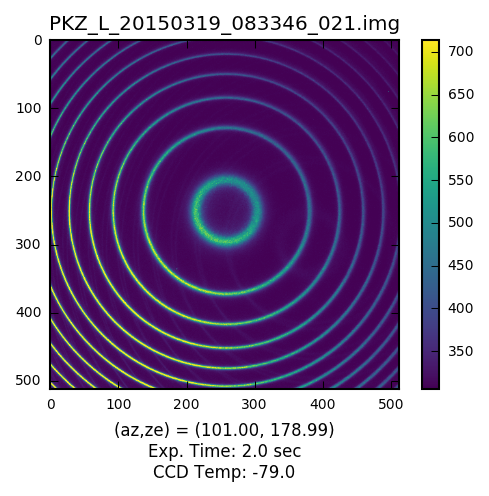

In [19]:
if letter == 'L':
    allim = laser_fns
elif letter == 'Y':
    allim = sky_fns
else:
    raise Exception('need "L" or "X"')
d = FPI.ReadIMG(allim[index])
img = np.asarray(d)
imshow(img, vmin = prctile(d,p=1), vmax = prctile(d, p=99), cmap='viridis')
colorbar()
plt.title(allim[index].split('/')[-1])
plt.xlabel('(az,ze) = (%.2f, %.2f)\nExp. Time: %.1f sec\nCCD Temp: %.1f' % (d.info['azAngle'], \
                                    d.info['zeAngle'],d.info['ExposureTime'],d.info['CCDTemperature']))

#savefig('/home/bhardin2/ipython_figures/mor_grainy.png')

index += 1

#clim((480,700))



## Center Finding

In [20]:
center_variation_max = 1.5

lasers_all = laser_fns[:]
sky_all =    sky_fns[:]
lasers_all.sort()
sky_all.sort()

if len(lasers_all)==0:
    raise Exception('No Laser images found in %s' % data_dir)

lasers = []
for fn in lasers_all:
    d = FPI.ReadIMG(fn)
    dt = local.localize(d.info['LocalTime'])
    lasers.append(fn)

# Initialize data holder
laser_times_center = []
laser_intT = []
laser_temperature = []
dt_laser = []
center = None
fnames_to_remove = []
for fname in lasers:
    # Read in the laser image and estimate the center location
    d = ReadIMG(fname)
    img = np.asarray(d)
    (cx,cy) = FindCenter(img)
    
    appx_I = matplotlib.mlab.prctile(img,95) - matplotlib.mlab.prctile(img,5)
    #print appx_I
    if appx_I < LAS_I_THRESH:
        print '%s laser fringes not bright enough to be trustworthy. Ignoring this image in the whole analysis...' % (fname)
        fnames_to_remove.append(fname)
    # Make sure valid data returned
    elif cx is not None and np.isfinite(cx):
        if center is None:
            center = [cx, cy]
        else:
            center = np.vstack((center, [cx, cy]))

        #logfile.write(datetime.datetime.now().strftime('%m/%d/%Y %H:%M:%S %p: ') + '%s center: %.2f, %.2f\n' % (fname, cx, cy))

        # Append the time of the laser image
        laser_times_center.append(local.localize(d.info['LocalTime']))
        laser_intT.append(d.info['ExposureTime'])
        laser_temperature.append(d.info['CCDTemperature'])
        
        dt_laser.append((laser_times_center[-1]-laser_times_center[0]).seconds)
        print fname # TODO: DELETE ME
        
    else:
        #logfile.write(datetime.datetime.now().strftime('%m/%d/%Y %H:%M:%S %p: ') + \
        #        '%s center is None or nan. Ignoring this in poly fit...\n' % (fname))
        print '%s center is None or nan. Ignoring this image in the whole analysis...' % (fname)
        fnames_to_remove.append(fname)
        
for fname in fnames_to_remove:
    lasers.remove(fname)

centersave = center.copy()

dt_laser = np.array(dt_laser)
# Try to do some initial quality control by judging the centerfinding
lt0 = local.localize(datetime.datetime(1989,4,18)) # placeholder, in case we use time-independent fit

# If there are no usable center locations, use the midpoint and write to the log.
if center is None or len(center)==0:
    mid = np.ceil(np.shape(d)[0]/2.0)
    cx = lambda t: mid
    cy = lambda t: mid
    print 'WARNING: Centerfinding failed for all laser images. Using midpoint of CCD, ' + \
            'but suggested solution is to use Zenith reference.\n'
    notify_the_humans = True
    
# If there is only one usable point, throw a warning but use this point.
elif np.shape(center)==(2,):
    cx = lambda t: center[0]
    cy = lambda t: center[1]
    print 'WARNING: Centerfinding failed for all but 1 laser image. Using it, but' + \
            ' suggested solution is to use Zenith reference.\n'
    notify_the_humans = True
    
    
else: # There are > 1 center points. Use them.
    # If we have too much variation in the center locations, remove outliers
    if (np.std(center,0) > center_variation_max).any(): # if variation is more than a few pixels, there's probably a bad point.
        cenx = center[:,0]
        ceny = center[:,1]
        print abs(cenx - np.mean(cenx)) /(np.std(cenx))
        good = (abs(cenx - np.mean(cenx)) < 2*np.std(cenx)) & (abs(ceny - np.mean(ceny)) < 2*np.std(ceny))
        #print ind
        center = center[good,:]
        dt_laser = dt_laser[good]
        # Should we ignore the laser images in the subsequent analysis? For now,
        # ignore them since these are probably invalid data, and will cause problems
        # with laser parameter interpolation.
        lasers = [fn for (fn, valid) in zip(lasers, good) if valid]
        laser_times_center = [t for (t, valid) in zip(laser_times_center, good) if valid]
        nignored = len(good) - sum(good)
        if nignored > 0:
            print '%03i laser images ignored because the center location is an outlier.\n' % nignored
            
    
    # If there are enough points after this, fit a poly to the center positions
    if len(dt_laser) > 0:
        lt0 = laser_times_center[0]
        npoly = np.ceil(len(dt_laser)/3) # use an adaptive degree polynomial to fit
        # Limit the maximum degree, because of numerical sensitivity for large orders.
        if npoly > 10:
            npoly = 10 
        pf_cx = np.polyfit(dt_laser,center[:,0],npoly)
        cx = np.poly1d(pf_cx)
        pf_cy = np.polyfit(dt_laser,center[:,1],npoly)
        cy = np.poly1d(pf_cy)
        if len(dt_laser) < 6:
            print 'WARNING: Very few (%i) laser images for center trending. Consider using Zenith reference.\n' % len(dt_laser)
            notify_the_humans = True

    else: # I don't think we can ever get to this point, but just in case:
        mid = np.ceil(np.shape(d)[0]/2.0)
        cx = lambda t: mid
        cy = lambda t: mid 
        print 'WARNING: No usable center points for polyfit. Using midpoint of CCD, ' + \
                'but suggested solution is to use Zenith reference.\n' 
        notify_the_humans = True            
        

/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_050829_001.img
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_051528_002.img
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_052538_003.img
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_053625_004.img
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_054643_005.img
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_055726_006.img
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_060736_007.img
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_061820_008.img
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_062831_009.img
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_063913_010.img
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_064924_011.img
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_070007_012.img
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_071017_013.img
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_072059_

[ 257.94819716  250.94946107]


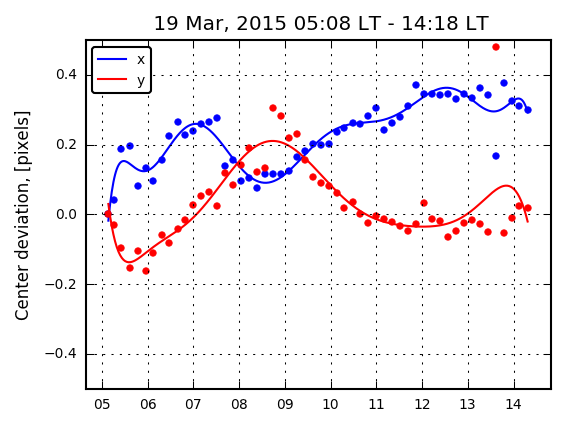

In [21]:
# Copied directly from FPI.py 2013/07/22
fig = figure()

fontP = FontProperties()
fontP.set_size('small')

tdiffvec = [laser_time - lt0 for laser_time in laser_times_center]
dt = np.array([tdiff.seconds + tdiff.days*86400. for tdiff in tdiffvec])
t = np.linspace(0, dt.max(), 500)
datet = [lt0 + datetime.timedelta(seconds=ts) for ts in t]

# Make a special plot if centerfinding failed
if len(center)==0 or shape(center)==(2,): # 0 or 1 usable points
    xdev = 0
    ydev = 0
    xdevi = np.zeros(len(t))
    ydevi = np.zeros(len(t))
else:
    xdev = center[:,0] - center[0,0]
    ydev = center[:,1] - center[0,1]
    xdevi = cx(t) - center[0,0]
    ydevi = cy(t) - center[0,1]
    
print center.mean(axis=0)

ax = fig.add_subplot(111)
ax.plot(datet, xdevi, 'b', label='x')
ax.plot(laser_times_center, xdev, 'b.')
ax.plot(datet, ydevi, 'r', label='y')
ax.plot(laser_times_center, ydev, 'r.')
ax.legend(loc='best', prop=fontP)
ax.set_xlim([laser_times_center[0] - datetime.timedelta(hours=0.5), laser_times_center[-1] + datetime.timedelta(hours=0.5)])
ax.xaxis.set_major_formatter(dates.DateFormatter('%H'))
m = 0.5 # maximum deviation to show on plot
if all(xdev < m) and all(xdev > -m) and all(ydev < m) and all(ydev > -m): # Set the x and y lims at +/- m 
    ax.set_ylim([-m, m])

ax.set_ylabel('Center deviation, [pixels]')
#ax.set_xlabel('Universal Time, [hours]')
ax.set_title(laser_times_center[0].strftime(' %d %b, %Y %H:%M LT') + ' - ' + laser_times_center[-1].strftime('%H:%M LT') )
ax.grid(True)


### Laser Fit

In [22]:
# Initialize values
output = []
last_chi = -999
laser_times = []
laser_redchi = []
last_t = instrument['nominal_t']
lam_laser = instrument['lam_laser']

# Loop through all of the lasers
for fname in lasers:
    
    # Read in the laser image and estimate the center location
    d = ReadIMG(fname)
    img = np.asarray(d)

    # Calculate the annuli to use for this time
    dt = (local.localize(d.info['LocalTime'])-lt0).seconds
    annuli = FindEqualAreas(img,cx(dt),cy(dt),N)

    # Perform annular summation
    laser_spectra, laser_sigma = AnnularSum(img,annuli,0)

    if not np.isnan(laser_spectra).any(): # Do the inversion. Otherwise, ignore it.
        
        ####### Find good initial guesses for the parameters ######
        
        # Magnification parameter by using geometry (assuming square binning)
        alpha = 0.85*instrument['pix_size']/instrument['focal_length'] * d.info['XBinning']
        # Intensity and background by looking at fringes
        I = laser_spectra.max() - laser_spectra.min()
        B = laser_spectra.min()
        
        laser_params = Parameters()
        laser_params.add('n',     value = 1.0,                           vary = False)
        laser_params.add('t',     value = None,                        vary = False)
        laser_params.add('lam',   value = lam_laser,                     vary = False)
        laser_params.add('R',     value = 0.5,                           vary = False)
        laser_params.add('alpha', value = alpha,                         vary = False)
        laser_params.add('I',     value = I,                             vary = False)
        laser_params.add('B',     value = B,                             vary = False)
        laser_params.add('a1',    value = 0.0,  min=-5.0, max=5.0,        vary = False)
        laser_params.add('a2',    value = 0.0,  min=-5.0, max=5.0,        vary = False)
        laser_params.add('b0',    value = 1.5,  min=-10.0, max=10.0,      vary = False)
        laser_params.add('b1',    value = 0.0,  min=-10.0, max=10.0,      vary = False)
        laser_params.add('b2',    value = 0.0,  min=-10.0, max=10.0,      vary = False)
        
        # To find a good initial guess for "t", we'll need to do a grid search.  Search
        # over 1 FSR around the last solved-for value (or the nominal value, if this is first trial).
        # TODO: make this grid search a separate general function.
        def goodness(t): 
            # return the correlation between the fringe with this t and the data
            laser_params['t'].value = t
            fringe = Laser_FringeModel(laser_params, annuli['r'])
            return np.dot(fringe, laser_spectra)/(norm(fringe)*norm(laser_spectra))
        t_candidates = linspace(last_t - lam_laser/4, last_t + lam_laser/4, 50)
        corrvec = np.array([goodness(t) for t in t_candidates])
        best_t = t_candidates[corrvec.argmax()]
        laser_params['t'].value = best_t
        
        ####### Inversion of laser image ##########
        
        # Now do least-squares fit, but in stages, varying only certain parameters at a time, according to:
        order = [
                 ['alpha'],\
                 ['t','alpha'],\
                 ['B','I'],\
                 ['R'],\
                 ['t','alpha','B','I','R','a1','a2'], \
                 ]
        if ESTIMATE_BLUR:
            order.append(['t','alpha','B','I','R','a1','a2','b0'])
           # order.append(['t','alpha','B','I','R','a1','a2','b0','b1','b2'])
        
        for group in order: # set all the params in this group to "vary=True", and then run inversion
            for param in laser_params.keys():
                if param in group:
                    laser_params[param].vary = True
                else:
                    laser_params[param].vary = False
            # Set falloff terms to false, if this instrument only has a couple fringes
            if not instrument['many_fringes']:
                for param in ['a2', 'b1', 'b2']:
                    laser_params[param].vary=False
                    laser_params[param].value=0.0
        
            laser_fit = Minimizer(Laser_Residual,laser_params, \
                fcn_args=(annuli['r'][N0:N1],), fcn_kws={'data': laser_spectra[N0:N1], 'sigma': laser_sigma[N0:N1]}, \
                scale_covar = True)
            laser_fit.leastsq()
        
       
        #if (laser_fit.redchi/laser_fit.params['I'].value < 1.): # TODO: try to find a better way to do this
        if True: # TODO: just keep this?
            # This is a valid image, store time
            laser_times.append(local.localize(d.info['LocalTime']))
            # Save the results
            output.append(laser_fit)
            
            last_chi = laser_fit.redchi
            last_t = best_t
            laser_redchi.append(laser_fit.redchi)
            #logfile.write(datetime.datetime.now().strftime('%m/%d/%Y %H:%M:%S %p: ') + \
            #        '%s reduced chisqr: %.4f\n' % (fname, laser_fit.redchi))
    
    print fname # TODO: DELETE ME
    print laser_fit.message
    
# Check if any laser images were actually analyzed.
if len(output)==0:
    raise Exception('%s: No usable laser images found.' % data_dir) 

/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_050829_001.img
Tolerance seems to be too small.
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_051528_002.img
Tolerance seems to be too small.
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_052538_003.img
Tolerance seems to be too small.
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_053625_004.img
Tolerance seems to be too small.
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_054643_005.img
Tolerance seems to be too small.
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_055726_006.img
Tolerance seems to be too small.
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_060736_007.img
Tolerance seems to be too small.
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_061820_008.img
Tolerance seems to be too small.
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_062831_009.img
Tolerance seems to be too small.
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_2015031

In [23]:
for param in laser_params:
    vals = [o.params[param].value for o in output]
    print '%06s: %.3e' % (param, median(vals)) 

     n: 1.000e+00
     t: 1.000e-02
   lam: 6.328e-07
     R: 7.975e-01
 alpha: 7.054e-05
     I: 3.163e+02
     B: 3.070e+02
    a1: -8.508e-02
    a2: 1.659e-02
    b0: 1.247e+00
    b1: 0.000e+00
    b2: 0.000e+00


In [24]:
# Show Laser fit
i = -1 # which laser image

/home/bhardin2/PKZ/20150319_Images/Images/PKZ_L_20150319_050829_001.img


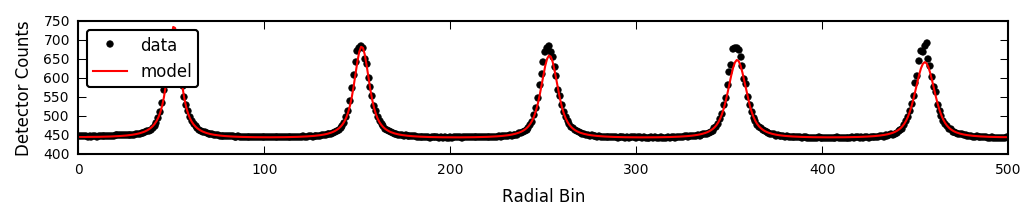

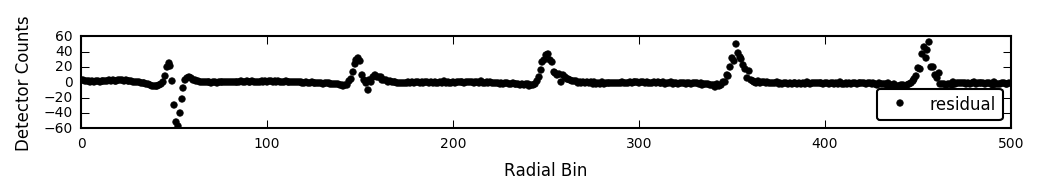

In [25]:
i = i + 1
# Make default figure size shorter and fatter
figure(figsize=(8,3))
subplot(2,1,1)

M0 = 0
M1 = N1-N0

o = output[i]
spectra = o.userkws['data']
sigma   = o.userkws['sigma']
model = spectra + sigma*o.residual

plot(spectra[M0:M1],'k.', label='data')
plot(model[M0:M1],'r',label='model')
xlabel('Radial Bin')
ylabel('Detector Counts')
legend(loc='best', prop={'size':8})
subplots_adjust(bottom=0.25) # or else the xlabel will be cut off, for some reason
#title(lasers[i])
print(lasers[i])

figure(figsize=(8,1.5))
subplot(2,1,2)


o = output[i]
spectra = o.userkws['data']
sigma   = o.userkws['sigma']
model = spectra + sigma*o.residual
resid = (spectra - model)

plot(resid,'k.', label='residual')
xlabel('Radial Bin')
ylabel('Detector Counts')
legend(loc='best', prop={'size':8})
subplots_adjust(bottom=0.0) # or else the xlabel will be cut off, for some reason


#fl = instrument['pix_size']*d.info['XBinning']/o.params['alpha'].value
#print fl

#savefig('/home/bhardin2/public_html/tmp/minime95_fringes.png')

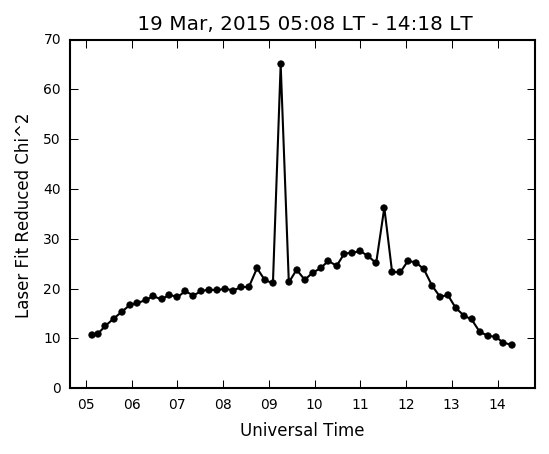

In [26]:
fig = figure(figsize=(4,3))
h = fig.add_subplot(111)
h.plot(laser_times, laser_redchi,'k.-')
h.xaxis.set_major_formatter(dates.DateFormatter('%H'))
h.set_xlim([laser_times[0] - datetime.timedelta(hours=0.5), laser_times[-1] + datetime.timedelta(hours=0.5)])
h.set_xlabel('Universal Time')
h.set_ylabel('Laser Fit Reduced Chi^2')
h.set_title(laser_times[0].strftime(' %d %b, %Y %H:%M LT') + ' - ' + laser_times[-1].strftime('%H:%M LT') )

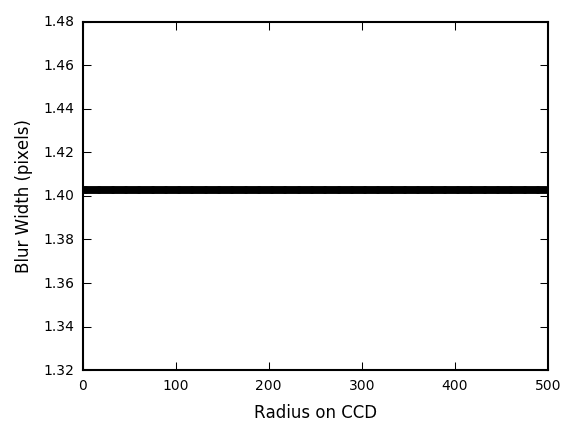

In [27]:
r = annuli['r'][N0:N1]
x = pi*r/r.max()
b0 = laser_params['b0']
b1 = laser_params['b1']
b2 = laser_params['b2']
b = b0 + b1*cos(x) + b2*sin(x)
plot(b,'k.-')
ylabel('Blur Width (pixels)')
xlabel('Radius on CCD')


### Spline Fit

In [28]:
######### Spline fit to the parameters ###########

# Grab the seconds from the first laser observation (required for spline interpolation)
dt = []
for x in laser_times:
    diff = (x - laser_times[0])
    dt.append(diff.seconds+diff.days*86400.)
dt = array(dt)

# Spline fit to the parameters.
# (This will work for both the fitted and constant params)
for param in laser_fit.params:
    # Grab the estimates and the associated (normalized) uncertanty
    p = []
    ep = []
    for o in output:
        p.append(o.params[param].value)
        ep.append(o.params[param].stderr)

    p = np.array(p)
    ep = np.array(ep)
    m = len(ep)
    s = m  # Expected value of chi^2

    if param == 't': # force 't' to fit more smoothly
        # i.e., we don't trust those small error bars, so make them bigger
        ep = ep * 3 # TODO: optimal value?  1 seems too small, 10 seems too big
    
    # set weights
    if laser_fit.params[param].vary:
        # use the error bars from the inversion, but
        # replace the values that are infinite, 
        # (i.e., where the errorbars couldn't be calculated)
        # with very large numbers.
        w = [1/stderr if stderr > 0 else 1/(1e6*paramval) for paramval,stderr in zip(p,ep) ]
    else: 
        # use arbitrary error bars (doesn't matter - it will fit exactly)
        w = np.ones(shape(ep))
    
        # Try spline, then linear, then zeroth-order interpolation
        
    try: # spline interpolation
        #sfit = interpolate.UnivariateSpline(np.array(dt),p, w=w, s=s)
        sfit = interpolate.interp1d(np.array(dt), p)
    except: # Try linear.
        notify_the_humans = True
        try: # if there's only one laser image, then even linear won't work.
            print 'Spline interpolation failed for laser param "%s". Defaulting to linear interpolation.\n' % (param)                
            sfit = interpolate.interp1d(np.array(dt), p)
        except: # all else failed. There's probably only one laser image.
            print 'Spline and linear interpolation both failed for laser param ' + \
                 '"%s". Defaulting to zeroth-order interpolation.\n' % (param)
            sfit = lambda t: p[0] # whatever the input, just return the parameter.
            
    laser_fit.params[param].spfit = sfit

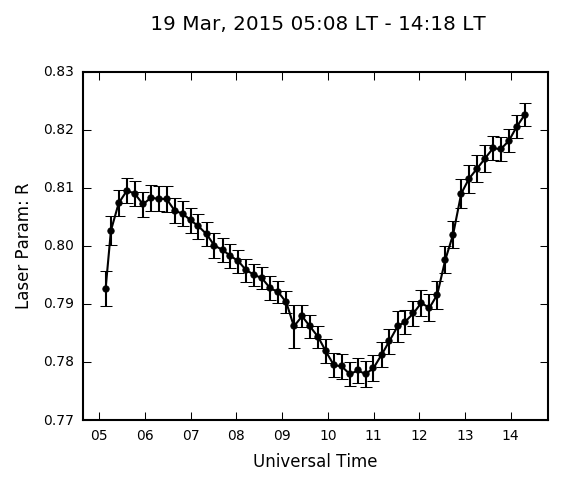

In [29]:
# Show the spline fit for a certain parameter
param = 'R'
dt_vec = linspace(0, max(dt), 500)
p_vec = laser_fit.params[param].spfit(dt_vec)
p = [o.params[param].value for o in output]
pe = [o.params[param].stderr for o in output]
datet_vec = [laser_times[0] + datetime.timedelta(seconds=ts) for ts in dt_vec]
fig = figure()
h = fig.add_subplot(111)
h.plot(datet_vec,p_vec,'k')
h.errorbar(laser_times,p,yerr=pe,fmt='k.')
h.set_xlim([laser_times[0] - datetime.timedelta(hours=0.5), laser_times[-1] + datetime.timedelta(hours=0.5)])
h.xaxis.set_major_formatter(dates.DateFormatter('%H'))
h.set_ylabel('Laser Param: %s' % param)
h.set_xlabel('Universal Time')
ti = h.set_title(laser_times[0].strftime(' %d %b, %Y %H:%M LT') + ' - ' + laser_times[-1].strftime('%H:%M LT') )
ti.set_y(1.09)

### Sky Fit

In [30]:
def get_moon_angle(t, lat, lon, az, ze):
    '''
    Calculate the great-circle angle between the direciton of the moon
    and the direction iven by (az,ze), for the datetime t and location (lat,lon)
    '''
    obs = ephem.Observer()
    obs.lat = str(lat)
    obs.lon = str(lon)
    obs.date = t.astimezone(pytz.utc)

    moon = ephem.Moon(obs)
    moonAz = moon.az.real
    moonZe = math.pi/2 - moon.alt.real

    # Code copied from original Master scripts for FPI observations
    a = math.cos(az*math.pi/180)*math.sin(ze*math.pi/180)
    b = math.sin(az*math.pi/180)*math.sin(ze*math.pi/180)
    aMoon = math.cos(moonAz)*math.sin(moonZe)
    bMoon = math.sin(moonAz)*math.sin(moonZe)
    moonAngle = math.acos(a*aMoon + b*bMoon + math.cos(ze*math.pi/180) * math.cos(moonZe))

    return moonAngle*180./pi
    
    
############# Invert the sky images ###############
# Grab all sky images. Don't use sky images when sun is up, 
# or before (after) the first (last) laser image, or if 
# the moon is too close to the line of sight.
sky = []
all_az = []
all_ze = []
for fn in sky_all[:]:
    d = ReadIMG(fn)
    dt = local.localize(d.info['LocalTime'])
    laserstraddle = dt > laser_times[0] and dt < laser_times[-1]
    all_az.append(d.info['azAngle'])
    all_ze.append(d.info['zeAngle'])
    if not laserstraddle: # Write to log and don't use this image
        #logfile.write(datetime.datetime.now().strftime('%m/%d/%Y %H:%M:%S %p: ') + '%s not bounded by laser images. Ignoring this image...\n' % fn )
        print('%s not bounded by laser images. Ignoring this image...\n' % fn )
    ######################## HACK TO ONLY ANALYZE ZENITH MEASUREMENTS ##############################
    #elif abs(d.info['zeAngle']) > 0.5:
    #    pass
    ################################################################################################
    else:
        sky.append(fn)

/home/bhardin2/PKZ/20150319_Images/Images/PKZ_Y_20150319_142031_185.img not bounded by laser images. Ignoring this image...

/home/bhardin2/PKZ/20150319_Images/Images/PKZ_Y_20150319_142342_186.img not bounded by laser images. Ignoring this image...



In [31]:
if len(sky) == 0:
    raise Exception('%s: No usable sky images found.' % data_dir)
    
# Constants
c = 299792458.
k = 1.3806503e-23
m = 16/6.0221367e26


# Initialize data holder
sky_times = []
az = []
ze = []
LOSwind = []
sigma_LOSwind = []
T = []
sigma_T = []
direction = []
sky_redchi = []
skyI = []
skyB = []
ccdB = []
sigma_skyI = []
sigma_skyB = []
sigma_ccdB = []
sky_out = []
sky_intT = []
sky_temperature = []

# Categorize the look directions in the directory
valid_az = array([site['Directions'][direc]['az'] for direc in site['Directions']])
valid_ze = array([site['Directions'][direc]['ze'] for direc in site['Directions']])
direc_names = site['Directions'].keys()
all_az = []
all_ze = []
for fname in sky:
    d = ReadIMG(fname)
    all_az.append(d.info['azAngle'])
    all_ze.append(d.info['zeAngle'])
    
    #print('%s: %.1f, %.1f' % (fname, d.info['azAngle'], d.info['zeAngle']))
    
direc_idx, dists = sort_look_directions(valid_az, valid_ze, all_az, all_ze, direc_tol)


lam0 = instrument['lam0']
last_lamc = lam0 # nominal value of line center
lamc_start_set = False # Turns true when a reasonable search interval center is found

my_params = dict()

for i, fname in enumerate(sky):
    # Read in the sky image
    d = ReadIMG(fname)
    img = np.asarray(d)
    
    # Calculate the annuli to use for this time
    dt = (local.localize(d.info['LocalTime'])-lt0).seconds
    annuli = FindEqualAreas(img,cx(dt),cy(dt),N)
    
    # Perform the annular summation
    sky_spectra, sky_sigma = AnnularSum(img,annuli,0)
    
    # See if there are any NaNs in the spectra.  If so, skip this one.
    if np.isnan(sky_spectra).sum() == 0:
        # Append the time of the sky image
        sky_times.append(local.localize(d.info['LocalTime']))
        sky_intT.append(d.info['ExposureTime'])
        sky_temperature.append(d.info['CCDTemperature'])
        
        # Record the look direction.
        # For the record, use "human-friendly" azimuth and zenith:
        temp_az = d.info['azAngle']
        temp_ze = d.info['zeAngle']
        if temp_ze < 0.0:
            temp_ze = abs(temp_ze)
            temp_az = np.mod(temp_az+180.0,360)
        az.append(temp_az)
        ze.append(temp_ze)
        # Change direction index into string
        idx_match = direc_idx[i] # This is a list like [1] or [1,3] or []
        # How many matches were there? Do something different for each case.
        direcstr = ''
        if len(idx_match)==0: # No match was found
            direcstr = 'Unknown'
            #logfile.write(datetime.datetime.now().strftime('%m/%d/%Y %H:%M:%S %p: ') + \
                #'%s has a look direction that is not recognized: Az=%.1f, Ze=%.1f.\n' % (fname, temp_az, temp_ze))
            print('%s has a look direction that is not recognized: Az=%.1f, Ze=%.1f.\n' % (fname, temp_az, temp_ze))
        elif len(idx_match)==1: # unique recognized look direction
            direcstr = direc_names[idx_match[0]]
        else: # more than one match was found
            # If "Zenith" is one of them, use it, otherwise, use any of them.
            # Write a warning to the log.
            direcstr_list = [direc_names[j] for j in idx_match]
            if 'Zenith' in direcstr_list:
                direcstr = 'Zenith'
            else:
                direcstr = direcstr_list[0]
                #logfile.write(datetime.datetime.now().strftime('%m/%d/%Y %H:%M:%S %p: ') + \
                #    '%s has a look direction with > 1 match: Az=%.1f, Ze=%.1f. ' + \
                #    'Matches: %s. Choosing: %s\n' % \
                #    (fname, temp_az, temp_ze, str(direcstr_list), direcstr))
            print('%s has a look direction with > 1 match: Az=%.1f, Ze=%.1f. Matches: %s. Choosing: "%s"\n' % (fname, temp_az, temp_ze, str(direcstr_list), direcstr) )
        direction.append(direcstr)

        # Grab the sky times
        diff = sky_times[-1] - laser_times[0]
        my_dt = diff.seconds+diff.days*86400.
        
        # Set the fitting parameter guesses
        sky_params = Parameters()

        # Use the spline-interpolated values for the instrument function at this time
        for param in laser_fit.params:
            sky_params.add(param, value = laser_fit.params[param].spfit(my_dt), vary = False)
       
        # But change the sky wavelength to lam0
        sky_params['lam'].value = lam0
        
        # Set up the forward model        
        L = 301
        A_1D, lamvec = get_conv_matrix_1D(sky_params, annuli['r'][N0:N1], L, lam0)
        
        # Come up with good initial guesses for the sky parameters
        skyI_guess = sky_spectra[N0:N1].max() - sky_spectra[N0:N1].min()
        skyB_guess = 0.0
        ccdB_guess = sky_spectra[N0:N1].min()
        
        sky_params.add('lamc', value = lam0,       vary = True ) # We'll do a grid search to find a good value for lamc
        sky_params.add('T',    value = 1000,       vary = True , min = 0.1, max = 5000.0)
        sky_params.add('skyI', value = skyI_guess, vary = True , min = 0.0)
        sky_params.add('skyB', value = skyB_guess, vary = True )
        sky_params.add('skym', value = 0.0,        vary = False) # Don't try to estimate skym (or should we?)
        sky_params.add('ccdB', value = ccdB_guess, vary = True )
        sky_params.add('lam0', value = lam0,       vary = False) # This is determined by chemistry so it can't change.
        

        
        # Do a grid search to find a good starting value for lamc.
        # The instrument bias might mean that lam0 is a really bad value to start with.
        # Search over one FSR around the last solved-for value (or the nominal value, if it's the first run).
        # It's not really important to sort by direction, since the instrument bias dominates.
        def goodness(lamc): 
            # return the correlation between the fringe with this lamc and the data
            sky_params['lamc'].value = lamc
            fringe = Sky_FringeModel(sky_params, annuli['r'][N0:N1], lamvec, A_1D)
            return np.dot(fringe, sky_spectra[N0:N1])/(norm(fringe)*norm(sky_spectra[N0:N1]))
        FSR = lam0**2/(2*sky_params['t'].value)
        lamc_candidates = linspace(last_lamc - FSR/2, last_lamc + FSR/2, 50)
        corrvec = np.array([goodness(lamc) for lamc in lamc_candidates])
        best_lamc = lamc_candidates[corrvec.argmax()]
        sky_params['lamc'].value = best_lamc
        
        # Make a copy for future debugging
        sky_params_init = Parameters()
        for p in sky_params:
            sky_params_init.add(p, value = sky_params[p].value)
        
        # Take the inversion in steps
        order = [
                 ['skyI'],\
                 ['skyI','ccdB'],\
                 ['skyI', 'ccdB', 'skyB'], \
                 ['skyI', 'ccdB', 'skyB', 'lamc', 'T'], \
                 ]
        
        for group in order: # set all the params in this group to "vary=True", and then run inversion
            for param in sky_params.keys():
                if param in group:
                    sky_params[param].vary = True
                else:
                    sky_params[param].vary = False
                    
            sky_fit = Minimizer(Sky_Residual,sky_params,fcn_args=(annuli['r'][N0:N1],lamvec,A_1D), \
                      fcn_kws={'data': sky_spectra[N0:N1], 'sigma': sky_sigma[N0:N1]}, scale_covar=True)
            sky_fit.prepare_fit()
            sky_fit.leastsq()
        
        # if the inversion failed, replace values with nans and set error bars to inf
        if not sky_fit.success or not sky_fit.errorbars:
            for p in sky_fit.params:
                sky_fit.params[p].value = np.nan
                sky_fit.params[p].stderr = np.inf
        
        sky_redchi.append(sky_fit.redchi)
        sky_out.append(sky_fit)

        # Transform from lamc to v and collect all parameters
        lamc = sky_params['lamc'].value
        sigma_lamc = sky_params['lamc'].stderr
        v = c * (lamc/lam0 - 1)
        sigma_v = c * sigma_lamc / lam0
        LOSwind.append(v) # negative sign
        sigma_LOSwind.append(sigma_v)
        T.append(sky_fit.params['T'].value)
        sigma_T.append(sky_fit.params['T'].stderr)
        skyI.append(sky_params['skyI'].value/sky_intT[-1])
        sigma_skyI.append(sky_params['skyI'].stderr/sky_intT[-1])
        skyB.append(sky_params['skyB'].value/sky_intT[-1])
        sigma_skyB.append(sky_params['skyB'].stderr/sky_intT[-1])
        #logfile.write(datetime.datetime.now().strftime('%m/%d/%Y %H:%M:%S %p: ') + '%s reduced chisqr: %.4f\n' % (fname, sky_fit.redchi))
        print('%s reduced chisqr: %.4f. Message:"%s"' % (fname, sky_fit.redchi, sky_fit.message))
        
        # use the lamc value to center the next grid search, if the error bars are small enough
        if sigma_v < SIGMA_V_THRESH and sigma_v > 0 and not lamc_start_set: # sigma_v==0 means it didn't converge
            last_lamc = lamc # save for next time
            lamc_start_set = True
            
        #print 'v=%0.1f\tsigma_v=%.1f\tnext_init=%.1f' % (v, sigma_v, c*(last_lamc/lam0 - 1) )


    else:
        #logfile.write(datetime.datetime.now().strftime('%m/%d/%Y %H:%M:%S %p: ') + '%s is invalid and not analyzed\n' % fname)
        print '%s is invalid and not analyzed' % fname
    
if len(sky) == 0:
    print '%s: No usable sky images found.' % data_dir
    raise Exception('%s: No usable sky images found.' % data_dir)    


# Convert sky_params to array
n = len(sky_out)
sky_value = {}
sky_stderr = {}
for p in sky_out[-1].params:
    sky_value[p] = np.zeros(n)
    sky_stderr[p] = np.zeros(n)
    for i in range(0,n):
        sky_value[p][i] = sky_out[i].params[p].value
        sky_stderr[p][i] = sky_out[i].params[p].stderr
        
# TODO: Save OH parameters
# TODO: Save doppler reference
        
# For now.....
sigma_fit_LOSwind = np.nan
sigma_cal_LOSwind = np.nan
laser_value = np.nan
laser_stderr = np.nan
reference = 'laser'

FPI_Results = {'sky_times': np.array(sky_times), 'sky_chisqr': np.array(sky_redchi),
             'skyI': np.array(skyI),'skyB': np.array(skyB), 'ccdB': np.array(ccdB),
             'sigma_skyI': np.array(sigma_skyI), 'sigma_skyB': np.array(sigma_skyB), 'sigma_ccdB': np.array(sigma_ccdB),
             'LOSwind': np.array(LOSwind), 'sigma_fit_LOSwind': np.array(sigma_fit_LOSwind),
             'sigma_cal_LOSwind': np.array(sigma_cal_LOSwind), 'sigma_LOSwind': np.array(sigma_LOSwind),
             'az': np.array(az), 'ze': np.array(ze),
             'T': np.array(T), 'sigma_T': np.array(sigma_T), 'direction': direction,
             'laser_times': np.array(laser_times), 'laser_chisqr': np.array(laser_redchi),
             'laser_value': laser_value, 'laser_stderr': laser_stderr,
             'sky_value': sky_value, 'sky_stderr': sky_stderr,
             'laser_intT': np.array(laser_intT), 'laser_temperature': np.array(laser_temperature),
             'sky_intT': np.array(sky_intT), 'sky_temperature': np.array(sky_temperature),
             'reference': reference, 'lam0': lam0, 'sky_fns': sky_fns, 'laser_fns':laser_fns, }
                

/home/bhardin2/PKZ/20150319_Images/Images/PKZ_Y_20150319_051028_001.img reduced chisqr: 1.9402. Message:"Tolerance seems to be too small."
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_Y_20150319_051337_002.img reduced chisqr: 2.1864. Message:"Tolerance seems to be too small."
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_Y_20150319_051727_003.img reduced chisqr: 2.6256. Message:"Tolerance seems to be too small."
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_Y_20150319_052038_004.img reduced chisqr: 1.5334. Message:"Tolerance seems to be too small."
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_Y_20150319_052347_005.img reduced chisqr: 1.4252. Message:"Tolerance seems to be too small."
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_Y_20150319_052621_006.img reduced chisqr: 1.3155. Message:"Tolerance seems to be too small."
/home/bhardin2/PKZ/20150319_Images/Images/PKZ_Y_20150319_052807_007.img reduced chisqr: 2.4841. Message:"Tolerance seems to be too small."
/home/bhardin2/PKZ/20150319

In [32]:
# Apply Doppler reference
dref,drefe = DopplerReference(FPI_Results, reference=reference)
FPI_Results['LOSwind'] = FPI_Results['LOSwind'] - dref
# For now, do not add extra error bar Doppler reference,
# because it is small and it's not clear how it should
# be calculated.

In [33]:
for p in sky_fit.params:
    print p,sky_fit.params[p].value

n 1.0
t 0.00999980310238
lam 7.32e-07
R 0.822232444948
alpha 7.05296883189e-05
I 429.093749768
B 318.243463786
a1 -0.168151585387
a2 0.0357120161427
b0 1.4001339021
b1 0.0
b2 0.0
lamc 7.31987737575e-07
T 1690.08278266
skyI 2.78074593303
skyB 0.581325894168
skym 0.0
ccdB 301.143628228
lam0 7.32e-07


(-1000, 1000)

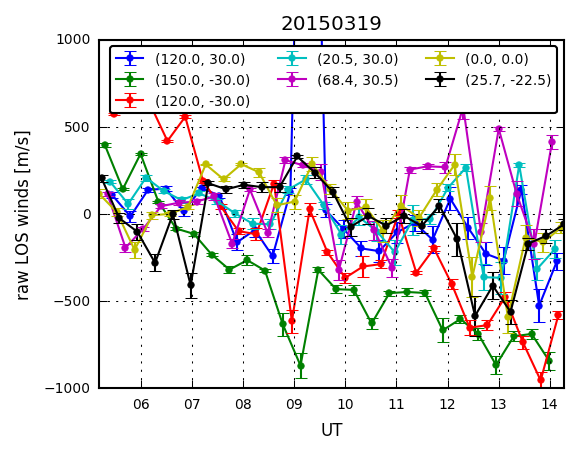

In [44]:
uniqdirecs = list(set(FPI_Results['direction']))
for direc in uniqdirecs:
    az = site['Directions'][direc]['az']
    ze = site['Directions'][direc]['ze']
    t = array([z for (z,d) in zip(FPI_Results['sky_times'], FPI_Results['direction']) if d == direc])
    x = array([z for (z,d) in zip(FPI_Results['LOSwind'], FPI_Results['direction']) if d == direc])
    xe = array([z for (z,d) in zip(FPI_Results['sigma_LOSwind'], FPI_Results['direction']) if d == direc])
    label = '(%.1f, %.1f)' % (az,ze)
    errorbar(t,x,yerr=xe,fmt='.-', label=label)
    
legend(loc='best',ncol=3)
gca().xaxis.set_major_formatter(dates.DateFormatter('%H'))
xlabel('UT')
ylabel('raw LOS winds [m/s]')
title(instrsitedate)
grid()
ylim((-1000,1000))

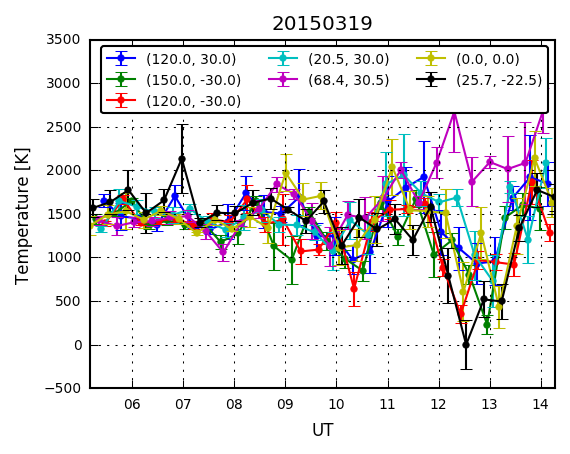

In [45]:
uniqdirecs = list(set(FPI_Results['direction']))
for direc in uniqdirecs:
    az = site['Directions'][direc]['az']
    ze = site['Directions'][direc]['ze']
    t = array([z for (z,d) in zip(FPI_Results['sky_times'], FPI_Results['direction']) if d == direc])
    x = array([z for (z,d) in zip(FPI_Results['T'], FPI_Results['direction']) if d == direc])
    xe = array([z for (z,d) in zip(FPI_Results['sigma_T'], FPI_Results['direction']) if d == direc])
    label = '(%.1f, %.1f)' % (az,ze)
    errorbar(t,x,yerr=xe,fmt='.-', label=label)
    
legend(loc='best',ncol=3)
grid()
gca().xaxis.set_major_formatter(dates.DateFormatter('%H'))
xlabel('UT')
ylabel('Temperature [K]')
title(instrsitedate)


In [42]:
f = open('/home/bhardin2/public_html/tmp/PKZ_732_%s.txt' % instrsitedate, 'w')
f.write(instrsitedate)
f.write('\n    Time    Direc      Az      Ze   LOSwind   Uncert.     Temp   Uncert.  Brightness      Uncert.\n')
f.write('                      deg     deg       m/s       m/s        K         K         arb          arb\n\n')
for i in range(len(FPI_Results['sky_times'])):
     f.write('%s   %06s   %5.1f   %5.1f   %6.1f     %5.1f   %6.1f     %5.1f      %5.4f   %5.8f\n' % (\
                    FPI_Results['sky_times'][i].strftime('%H:%M:%S'), FPI_Results['direction'][i],
                    FPI_Results['az'][i], FPI_Results['ze'][i], FPI_Results['LOSwind'][i], FPI_Results['sigma_LOSwind'][i],
                    FPI_Results['T'][i],FPI_Results['sigma_T'][i],FPI_Results['skyI'][i],FPI_Results['sigma_skyI'][i]))
f.close()

In [37]:
# Show SKy fit
i = 0 # which sky image

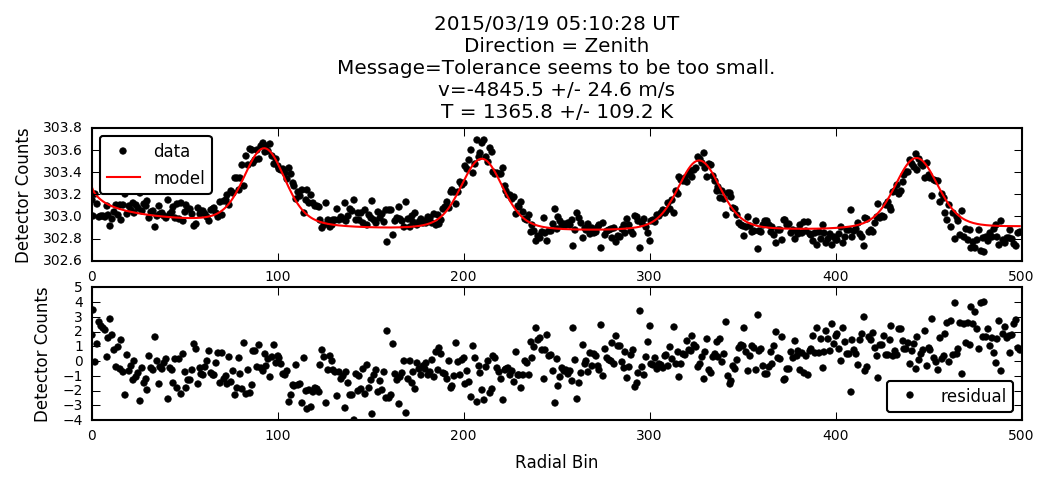

In [38]:
M0 = N0
M1 = N1

# Make default figure size shorter and fatter
figure(figsize=(8,3))
subplot(2,1,1)
o = sky_out[i]
spectra = o.userkws['data']
sigma   = o.userkws['sigma']
model = spectra + sigma*o.residual

plot(spectra[M0:M1],'k.', label='data')
plot(model[M0:M1],'r',label='model')
xlabel('Radial Bin')
ylabel('Detector Counts')
legend(loc='best', prop={'size':8})
subplots_adjust(bottom=0.25) # or else the xlabel will be cut off, for some reason
plt.title('%s %s\nDirection = %s\nMessage=%s\nv=%.1f +/- %0.1f m/s\nT = %.1f +/- %.1f K' % \
          (sky_times[i].astimezone(pytz.utc).strftime('%Y/%m/%d %H:%M:%S'),'UT',
           direction[i],o.message,LOSwind[i],sigma_LOSwind[i],T[i],sigma_T[i]))


subplot(2,1,2)

plot(o.residual[M0:M1],'k.', label='residual')
xlabel('Radial Bin')
ylabel('Detector Counts')
legend(loc='best', prop={'size':8})
#subplots_adjust(bottom=0.25) # or else the xlabel will be cut off, for some reason

i = i + 1


Plot all fringes from a given direction

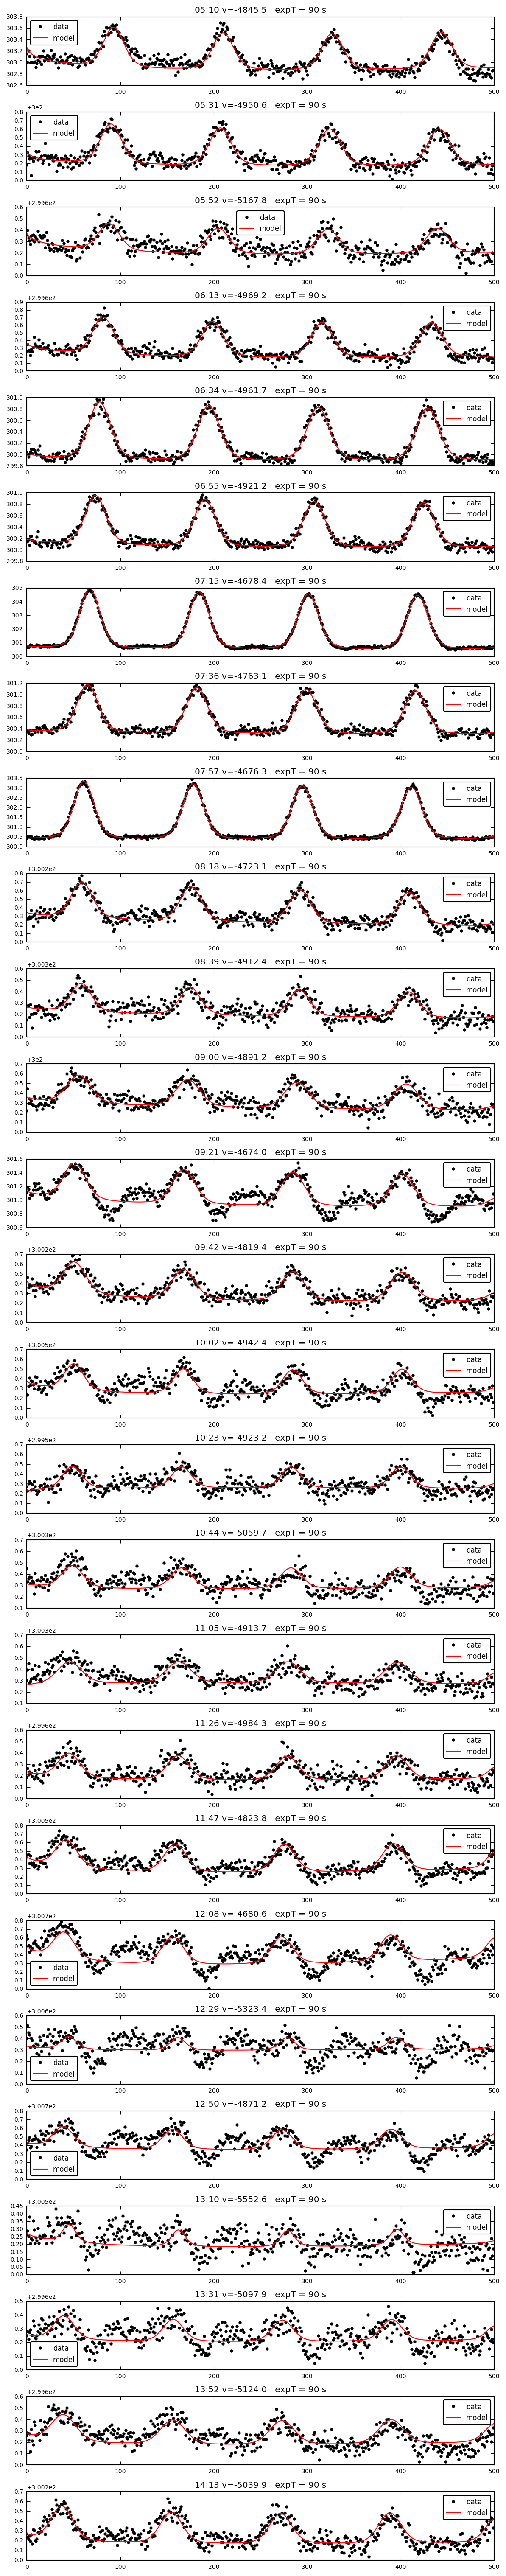

In [39]:
direc = 'Zenith'
M0 = N0
M1 = N1

idxvec = []
for i in range(len(sky_times)):
    if direction[i] == direc:
        idxvec.append(i)
K = len(idxvec)

figure(figsize=(8,1.5*K))

for ii in range(K):
    i = idxvec[ii]

    subplot(K,1,ii+1)
    o = sky_out[i]
    spectra = o.userkws['data']
    sigma   = o.userkws['sigma']
    model = spectra + sigma*o.residual

    plot(spectra[M0:M1],'k.', label='data')
    plot(model[M0:M1],'r',label='model')
    #ylabel('Detector Counts')
    legend(loc='best', prop={'size':8})
    title('%s v=%.1f   expT = %.0f s' % \
          (sky_times[i].astimezone(pytz.utc).strftime('%H:%M'),LOSwind[i],sky_intT[i]))
tight_layout()
#savefig('/home/bhardin2/public_html/tmp/moon_%s.png' % direc,dpi=150)
